<a href="https://colab.research.google.com/github/NiazG/ml_zoomcamp/blob/main/HW4_Niiaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-09 13:03:18--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.07s   

2023-10-09 13:03:18 (19.6 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [3]:
import pandas as pd
import numpy as np

In [118]:
data = pd.read_csv('data.csv')
data = data[[
'Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']]

data = data.rename(columns = {'MSRP':'price'})
data.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [119]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data = data.fillna(0)

data['above_average'] = np.where(data.price >= data.price.mean(), 1, 0)

data.drop("price", axis=1, inplace=True)

In [120]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


**Question 1**

In [112]:
from sklearn.model_selection import train_test_split

numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'above_average']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

df_train_full, df_test = train_test_split(data[categorical + numerical], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

numerical = numerical[:-1]

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for n in numerical:
    auc = roc_auc_score(y_train,df_train[n])
    if auc<0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    print('%s, %.3f' % (n, auc))

year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
city_mpg, 0.673


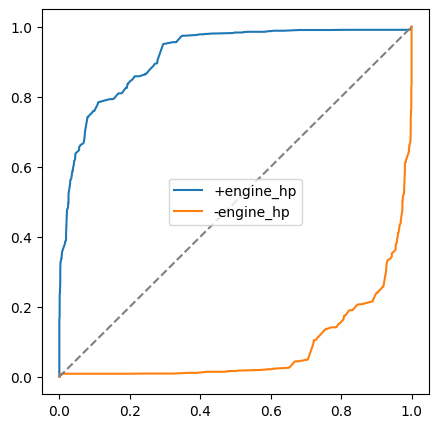

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='+engine_hp')

fpr, tpr, _ = roc_curve(y_train, -df_train.engine_hp)
plt.plot(fpr, tpr, label='-engine_hp')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

**Question 2**

In [149]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val,y_pred).round(4)

0.9797

**Question 3**

In [150]:
def confusion_matrix(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [151]:
df_scores = confusion_matrix(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,330,10,1399
20,0.2,623,203,31,1526
30,0.3,606,133,48,1596
40,0.4,593,103,61,1626
50,0.5,569,69,85,1660
60,0.6,552,49,102,1680
70,0.7,510,26,144,1703
80,0.8,467,15,187,1714
90,0.9,377,3,277,1726


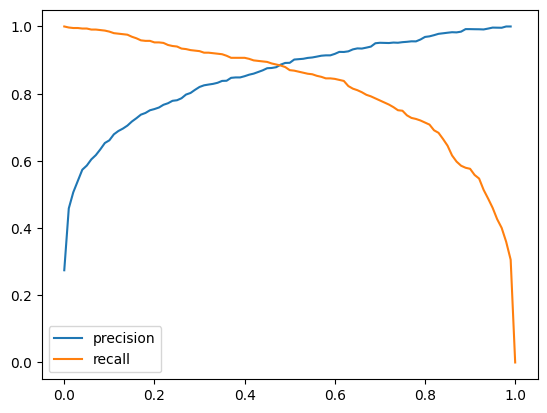

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.legend()
plt.show()


**Question 4**

In [160]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [164]:
df_scores.loc[df_scores.f1.idxmax()]

threshold       0.490000
tp            575.000000
fp             70.000000
fn             79.000000
tn           1659.000000
precision       0.891473
recall          0.879205
f1              0.885296
Name: 49, dtype: float64

Question 5

In [172]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

dv = DictVectorizer(sparse=False)

for train_idx, val_idx in kf.split(df_train_full):

    df_train_fold = df_train_full.iloc[train_idx]
    df_val_fold = df_train_full.iloc[val_idx]

    y_train_fold = df_train_fold.above_average.values
    y_val_fold = df_val_fold.above_average.values

    del df_train_fold["above_average"]
    del df_val_fold["above_average"]

    train_dicts = df_train_fold.to_dict(orient='records')
    val_dicts = df_val_fold.to_dict(orient='records')

    X_train_fold = dv.fit_transform(train_dicts)
    X_val_fold = dv.transform(val_dicts)

    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc_fold)

print("Standard Deviation of AUC Scores:", np.std(auc_scores))

Standard Deviation of AUC Scores: 0.002060199182252492


**Question 6**

In [173]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

dv, model = train(df_train, y_train, C=0.001)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [176]:
scores_all = []
y_pred = predict(df_val, dv, model)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

len(y_val), len(y_pred)
n_splits = 5

for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    scores_all.append((C, np.mean(scores), np.std(scores)))

scores_all = pd.DataFrame(scores_all, columns=['C', 'mean', 'std'])
scores_all

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,C,mean,std
0,0.01,0.951638,0.002473
1,0.10,0.972197,0.001529
2,0.50,0.979069,0.003178
3,10.00,0.979899,0.003239
